# Stock prediction using Long short-term memory 

An LSTM is a type of recurrent neural network that addresses the vanishing gradient problem in traditional RNNs. By using a gating mechanism that selectively recalls or forgets information, LSTM networks deal with this problem. In essence, LSTM uses past data in a particular way. It uses data that the neural network has seen and 'forgets' irrelevant data.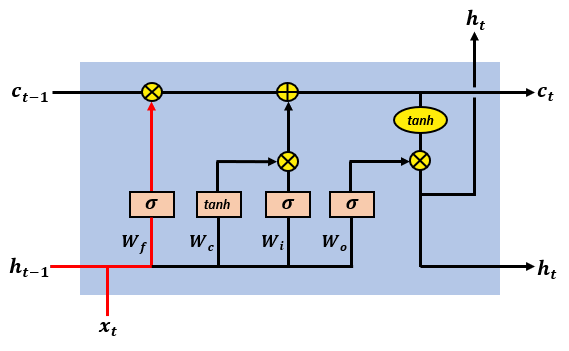


Some of its most common uses are:
- language modeling, such as translation, and 
- time series forecasting such as predicting weather, energy consumption and **stock prices**!

In [68]:
#import libraries

import yfinance as yf
import pandas as pd
import datetime as datetime
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential, load_model, model_from_json
from sklearn.metrics import mean_squared_error as MSE
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt

#visualization libraries
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

Get past5 years of stock data 

In [2]:
# get today's date
end_date = datetime.datetime.today().strftime("%Y-%m-%d")

#we will train our model individually on three different stocks 
tickers = ["AAPL", "MSFT", "AMZN"]

# get past 5 years of data
start_date = (datetime.datetime.today() - datetime.timedelta(days=365*5)).strftime("%Y-%m-%d")
stock_data = yf.download(tickers, start=start_date, end=end_date)

[*********************100%***********************]  3 of 3 completed


Keep only values for close and reorganize dataframe

In [3]:
stock_data_close = stock_data['Close']

In [4]:
stock_data_close

,AAPL,AMZN,MSFT
Date,,,
2018-08-31 00:00:00-04:00,56.907501,100.635498,112.330002
2018-09-04 00:00:00-04:00,57.090000,101.975502,111.709999
2018-09-05 00:00:00-04:00,56.717499,99.740997,108.489998
2018-09-06 00:00:00-04:00,55.775002,97.915497,108.739998
2018-09-07 00:00:00-04:00,55.325001,97.603500,108.209999
...,...,...,...
2023-08-23 00:00:00-04:00,181.119995,135.520004,327.000000
2023-08-24 00:00:00-04:00,176.380005,131.839996,319.970001
2023-08-25 00:00:00-04:00,178.610001,133.259995,322.980011


Split data now in train and test.<br>We will use a standard 80/20 split

In [5]:
data_split = int(stock_data_close.shape[0] * 0.8)

df_train, df_test = stock_data_close[:data_split], stock_data_close[data_split:]

Scale data to speed up conversion in the model

In [6]:
scaled_df_train = {}
scaled_df_test = {}
train_scaler = {}
test_scaler = {}

for i in tickers:
    min_maxscaler = MinMaxScaler(feature_range=(0,1))
    scaled_df_train[i] = min_maxscaler.fit_transform(df_train[[i]])
    train_scaler[i] = min_maxscaler
    
for i in tickers:
    min_maxscaler = MinMaxScaler(feature_range=(0,1))
    scaled_df_test[i] = min_maxscaler.fit_transform(df_test[[i]])
    test_scaler[i] = min_maxscaler

Now, we will use the previous 60 trading days to train the model

In [7]:
#train data

train = {}
for stock in tickers:
    #dict inside dict for each stock to have x and y values
    train[stock] = {}
    x_train = []
    y_train = []
    for i in range(60, len(scaled_df_train[stock])):
        x_train.append(scaled_df_train[stock][i-60:i,0])
        y_train.append(scaled_df_train[stock][i,0])
    #convert list into array
    x_train, y_train = np.array(x_train), np.array(y_train)
    #reshape data
    train[stock]['X'] = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    train[stock]['y'] = y_train

    
#test data

test = {}
for stock in tickers:
    test[stock] = {}
    x_test = []
    y_test = []
    for i in range(60, len(scaled_df_test[stock])):
        x_test.append(scaled_df_test[stock][i-60:i,0])
        y_test.append(scaled_df_test[stock][i,0])
    #convert list into array
    x_test, y_test = np.array(x_test), np.array(y_test)
    #reshape data
    test[stock]['X'] = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    test[stock]['y'] = y_test

Now we can start building our model

Build LSTM Model

In [8]:
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
lstm_model = Sequential()
#no layers 
lstm_model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
lstm_model.add(LSTM(50, return_sequences = False))
#no neurons
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

#compile model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

Fit model

In [70]:
for i in tickers:
    lstm_model.fit(train[i]['X'], train[i]['y'], batch_size=32, epochs=100, callbacks=[early_stop])
    lstm_model.save('model.'.format(i))

Epoch 1/100
30/30 [==============================] - 1s 40ms/step - loss: 3.2912e-04
Epoch 2/100
30/30 [==============================] - 1s 38ms/step - loss: 2.8515e-04
Epoch 3/100
30/30 [==============================] - 1s 39ms/step - loss: 2.5658e-04
Epoch 4/100
30/30 [==============================] - 1s 38ms/step - loss: 2.6036e-04
Epoch 5/100
30/30 [==============================] - 1s 40ms/step - loss: 2.6014e-04
Epoch 6/100
30/30 [==============================] - 1s 37ms/step - loss: 2.5010e-04
Epoch 7/100
30/30 [==============================] - 1s 38ms/step - loss: 2.6504e-04
Epoch 8/100
30/30 [==============================] - 1s 38ms/step - loss: 2.6166e-04
Epoch 9/100
30/30 [==============================] - 1s 39ms/step - loss: 2.7856e-04
Epoch 10/100
30/30 [==============================] - 1s 38ms/step - loss: 2.6557e-04
Epoch 11/100
30/30 [==============================] - 1s 39ms/step - loss: 3.1296e-04
Epoch 11: early stopping


INFO:tensorflow:Assets written to: model.\assets


INFO:tensorflow:Assets written to: model.\assets


Epoch 1/100
30/30 [==============================] - 1s 47ms/step - loss: 3.0228e-04
Epoch 2/100
30/30 [==============================] - 1s 42ms/step - loss: 2.9310e-04
Epoch 3/100
30/30 [==============================] - 1s 42ms/step - loss: 2.6624e-04
Epoch 4/100
30/30 [==============================] - 1s 43ms/step - loss: 2.8106e-04
Epoch 5/100
30/30 [==============================] - 1s 42ms/step - loss: 2.7547e-04
Epoch 6/100
30/30 [==============================] - 1s 42ms/step - loss: 3.2532e-04
Epoch 7/100
30/30 [==============================] - 1s 41ms/step - loss: 3.0874e-04
Epoch 8/100
30/30 [==============================] - 1s 43ms/step - loss: 2.8417e-04
Epoch 8: early stopping


INFO:tensorflow:Assets written to: model.\assets


INFO:tensorflow:Assets written to: model.\assets


Epoch 1/100
30/30 [==============================] - 1s 49ms/step - loss: 6.5522e-04
Epoch 2/100
30/30 [==============================] - 1s 44ms/step - loss: 6.7723e-04
Epoch 3/100
30/30 [==============================] - 1s 45ms/step - loss: 6.3028e-04
Epoch 4/100
30/30 [==============================] - 1s 47ms/step - loss: 6.3005e-04
Epoch 5/100
30/30 [==============================] - 1s 49ms/step - loss: 6.1429e-04
Epoch 6/100
30/30 [==============================] - 2s 50ms/step - loss: 7.6218e-04
Epoch 7/100
30/30 [==============================] - 2s 50ms/step - loss: 6.6321e-04
Epoch 8/100
30/30 [==============================] - 1s 49ms/step - loss: 7.3425e-04
Epoch 9/100
30/30 [==============================] - 1s 45ms/step - loss: 6.9739e-04
Epoch 10/100
30/30 [==============================] - 1s 45ms/step - loss: 7.3533e-04
Epoch 10: early stopping


INFO:tensorflow:Assets written to: model.\assets


INFO:tensorflow:Assets written to: model.\assets


Get predicted prices

In [74]:
#store all models in a dictionary
models = {}

for i in tickers:    
    #load models
    models['lstm_model_'+i] = load_model('model.'.format(i))
    
    #make predictions
    scaled_predictions = models['lstm_model_'+i].predict(test[i]['X']);
    
    #rescale predictions
    y_hat = test_scaler[i].inverse_transform(scaled_predictions);
    #rescale original y values
    y = test_scaler[i].inverse_transform(test[i]['y'].reshape(-1,1));
    #compute rsme
    rmse = sqrt(MSE(y_hat, y));
    
    
    #visualization
    df_y_hat = pd.DataFrame(y_hat)
    df_y_hat.columns = [i]
    df_y_hat['date'] = stock_data_close[-len(y_hat):].index
    
    df_y = pd.DataFrame(y)
    df_y.columns = [i]
    df_y['date'] = stock_data_close[-len(y_hat):].index
    
    
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x= df_y['date'],
            y = df_y[i],
            name= 'Real Stock Prices',
            line=dict(color='blue', width=0.7)))

    # add predicted stock prices
    fig.add_trace(
        go.Scatter(
        x = df_y_hat['date'],
        y = df_y_hat[i],
        name = 'Predicted Stock Prices',
        mode ='lines',
        line = dict(color='red', width=1.5)))


    fig.update_layout(
            title= 'Real Stock Prices vs Predicted by LSTM\n\nRMSE {}'.format(rmse),
            xaxis_title = "Date", 
            yaxis_title = 'Value')
    
    fig.show()
    

6/6 [==============================] - 1s 23ms/step


6/6 [==============================] - 1s 25ms/step


6/6 [==============================] - 1s 28ms/step


Predict prices for next 30 days<br>
For that we need to use the last predicted values of the model as inputs

In [75]:
#how many days we wanto to predict into the future
num_prediction_days = 30
#create a list to store predicted prices
predicted_prices=[]

#today's date
today = datetime.datetime.today()
#date in 30 days
day_30 = (datetime.datetime.today() + datetime.timedelta(days=30)).strftime("%Y-%m-%d")

for i in tickers:
    input_predict_data = pd.DataFrame(scaled_df_test[i])
    current_sequence = input_predict_data[-60:]

    for _ in range(num_prediction_days):
        # Predict the next day's price
        predicted_price = models['lstm_model_'+i].predict(np.array([current_sequence]))

        # Store the predicted price
        predicted_prices.append(predicted_price[0, 0])  # Assuming a single-output model

        # Update the current sequence with the predicted price
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = predicted_price
    
    y_hat_future = test_scaler[i].inverse_transform(np.array(predicted_prices).reshape(-1, 1));

    #visualization
    df_y_hat_future = pd.DataFrame(y_hat_future)
    df_y_hat_future.columns = [i]
    df_y_hat_future['date'] = pd.date_range(start=today, end = day_30, freq ='D')
    
    
    df_y = pd.DataFrame(y)
    df_y.columns = [i]
    df_y['date'] = stock_data_close[-df_y.shape[0]:].index
    
    
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x= df_y['date'],
            y = df_y[i],
            name= 'Real Stock Prices',
            line=dict(color='blue', width=0.7)))

    # add predicted stock prices
    fig.add_trace(
        go.Scatter(
        x = df_y_hat_future['date'],
        y = df_y_hat_future[i],
        name = '{} - day Predicted Future Stock Prices'.format(str(num_prediction_days)),
        mode ='lines',
        line = dict(color='red', width=1.5)))


    fig.update_layout(
            title= 'Real Stock Prices and Predicted by LSTM',
            xaxis_title = "Date", 
            yaxis_title = 'Value')
    
    fig.show()
    
    

1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 17ms/step


ValueError: Length of values (30) does not match length of index (60)